# EE359-Coursework 4  Streaming Algorithm
Existing codes in this file are just hints. You can modify these codes as you want

## **Task1：DGIM**

DGIM is an efficient algorithm in processing large streams. When it's infeasible to store the flowing binary stream, DGIM can estimate the number of 1-bits in the window. In this coding, you're given the stream_data_dgim.txt (binary stream), and you need to implement the DGIM algorithm to count the number of 1-bits. Write code below.

### 1. Set the window size to 1000, and count the number of 1-bits in the current window.

In [1]:
from collections import defaultdict

class DGIM:
    def __init__(self, filepath, windowsize, maxtime = None):
        self.fileHandler = open(filepath, 'r')
        self.windowSize = windowsize
        self.buckets = defaultdict(list)
        self.timeMod = maxtime if maxtime else windowsize << 2
        self.timestamp = 0
        
        self.logs = []
        self.count_size = self.windowSize
        self.filepath = filepath


    def _reset(self):
        self.fileHandler = open(self.filepath, 'r')
        self.buckets = defaultdict(list)
        self.timestamp = 0
        self.logs = []


    def _check_window(self):
        if len(self.buckets) == 0:
            return
        max_size = max(self.buckets.keys())
        if self.timestamp - self.buckets[max_size][0] >= self.windowSize:
            del self.buckets[max_size][0]
            if len(self.buckets[max_size]) == 0:
                del self.buckets[max_size]

    
    def _update(self):
        size = 1
        while (len(self.buckets[size]) == 3):
            end_time = self.buckets[size][1]
            del self.buckets[size][0]
            del self.buckets[size][0]

            self.buckets[size+1].append(end_time)
            size += 1

            
    def _in_window(self, time):
        start = self.timestamp - self.count_size
        if start < 0:
            start += self.timeMod
            return (time >= start) or (time <= self.timestamp)
        else:
            return (start <= time) and (time <= self.timestamp)


    def _count(self):
        total = 0
        visit_last_size = -1

        for size, bucket in self.buckets.items():
            for i in range(len(bucket)):
                if self._in_window(bucket[i]):
                    total += ( 1 << (size-1) )
                    visit_last_size = size-1

        if visit_last_size > 0:
            total -= ( 1 << (visit_last_size-1) )
        self.logs.append((self.timestamp, total))
        return total

    
    def run(self):
        f = self.fileHandler
        x = f.read(2).strip()
        while x:
            self._check_window()
            if x == '1':
                self.buckets[1].append(self.timestamp)
                self._update()
            self._count()
            self.timestamp = (self.timestamp + 1) % self.timeMod
            x = f.read(2).strip()

    
    def count(self, count_size):
        self.count_size = count_size
        return self._count()

    
    def count_all(self, count_size):
        self._reset()
        self.count_size = count_size
        self.run()
        return self.logs


In [2]:
dgim = DGIM(filepath="./stream_data_dgim.txt", windowsize=1000)
dgim.run()
print(dgim.count(1000))

508


### 2. With the window size 1000, count the number of 1-bits in the last 500 and 200 bits of the bitstream.

In [3]:
# code here

print(dgim.count(500))
print(dgim.count(200))

220
76


### 3. Write a function that accurately counts the number of 1-bits in the current window. Caculate the accuracy of your own DGIM algorithm and compare the running time difference.

In [4]:
# Your code here, you can add cells if necessary
import numpy as np
import time

def accurateCountTask1(filepath, windowsize):
    f = open(filepath, 'r')
    queue = [0] * windowsize
    idx = 0
    logs = []
    x = f.read(2).strip()
    while x:
        queue[idx] = int(x)
        idx = (idx + 1) % windowsize
        x = f.read(2).strip()
        
    count = 0
    for q in queue:
        count += q

    f.close()
    return count

def accurateCount_all(filepath, windowsize):
    f = open(filepath, 'r')
    queue = [0] * windowsize
    idx = 0
    logs = []
    x = f.read(2).strip()
    while x:
        queue[idx] = int(x)
        idx = (idx + 1) % windowsize
        count = 0
        for q in queue:
            count += q
        logs.append((idx, count))
        x = f.read(2).strip()
    f.close()
    return logs


start_time = time.perf_counter()
acc = accurateCountTask1("./stream_data_dgim.txt", 1000)
print("DGIM: %s seconds" % (time.perf_counter() - start_time))

start_time = time.perf_counter()
dgim_comp = DGIM(filepath="./stream_data_dgim.txt", windowsize=1000)
dgim_comp.run()
result = dgim_comp.count(1000)
print("AccCount: %s seconds" % (time.perf_counter() - start_time))

print()
print("DGIM: ", result)
print("Accurate: ", acc)
print("Accuracy:", (1. - np.abs(acc - result) / acc) * 100, "%")

DGIM: 0.010975350000002493 seconds
AccCount: 0.17192429199999992 seconds

DGIM:  508
Accurate:  391
Accuracy: 70.076726342711 %


In [5]:
print("Comparison on counting all windows.")
print("===================================")


start_time = time.time()
dgim_comp = DGIM(filepath="./stream_data_dgim.txt", windowsize=1000)
logs = dgim_comp.count_all(1000)

print("DGIM: %s seconds" % (time.time() - start_time))

start_time = time.time()
logs_acc = accurateCount_all("./stream_data_dgim.txt", 1000)
print("AccCount: %s seconds" % (time.time() - start_time))

errors = []
for i in range(len(logs)):
    errors.append( abs(logs[i][1] - logs_acc[i][1]) / (logs_acc[i][1] + 1e-8) )

print()
print("Avg. Accuracy: {:.2f}% \nAvg. Error: {:.2f}% \t Max. Error: {:.2f}% \t Max absolute Error: {}".format( 
        (1. - np.mean(errors)) * 100., np.mean(errors) * 100., np.max(errors)*100., np.max(np.abs(np.array(logs)[:,1] - np.array(logs_acc)[:,1]))) )

# print(logs[-1][1])
# print(logs_acc[-1][1])

Comparison on counting all windows.
DGIM: 0.18091535568237305 seconds
AccCount: 0.6256918907165527 seconds

Avg. Accuracy: 88.31% 
Avg. Error: 11.69% 	 Max. Error: 35.96% 	 Max absolute Error: 128


## **Task2: Bloom Filter**

A Bloom filter is a space-efficient probabilistic data structure. Here the task is to implement a bloom filter by yourself. 

### Data loading:

From the NLTK (Natural Language ToolKit) library, we import a large list of English dictionary words, commonly used by the very first spell-checking programs in Unix-like operating systems.

In [6]:
import nltk
from nltk.corpus import words
word_list = words.words()

Then we load another dataset from the NLTK Corpora collection: movie_reviews.

The movie reviews are categorized between positive and negative, so we construct a list of words (usually called bag of words) for each category.

In [7]:
from nltk.corpus import movie_reviews

neg_reviews = []
pos_reviews = []

for fileid in movie_reviews.fileids('neg'):
  neg_reviews.extend(movie_reviews.words(fileid))
for fileid in movie_reviews.fileids('pos'):
  pos_reviews.extend(movie_reviews.words(fileid))

Here we get a data stream (word_list) and 2 query lists (neg_reviews and pos_reviews).

### 1. Write a function that accurately determines whether each word in neg_reviews and pos_reviews belongs to word_list.

In [8]:
import numpy as np
import time

def linear_search(word_list, target_word):
    for word in word_list:
        if word == target_word:
            return True
    return False

In [9]:
# Binary search
neg_flag_b = np.zeros(len(neg_reviews), dtype=bool)
pos_flag_b = np.zeros(len(pos_reviews), dtype=bool)
# to store the accurate result

t = time.time()
sorted_word_list = sorted(word_list)
for i, neg_word in enumerate(neg_reviews):
    neg_flag_b[i] = linear_search(sorted_word_list, neg_word)
for i, pos_word in enumerate(pos_reviews):
    pos_flag_b[i] = linear_search(sorted_word_list, pos_word)
print("Search Time:", time.time() - t)

Search Time: 3512.296115398407


 ### 2. Implement the bloom filter by yourself and add all words in word_list in your bloom filter. Compare the running time difference between exact search (Task2 Question1) and multiple hash computations in a Bloom filter.

In [10]:
# Your code here, you can add cells if necessary
import hashlib

class BloomFilter:
    def __init__(self, m, k):
        self.m = int(m)
        self.k = int(k)
        self.table = np.zeros((self.m), dtype = bool)

    def add(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.m
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.m
        h = hash1
        for _ in range(self.k):
            self.table[h] = True
            h = (h + hash2) % self.m

    def check(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.m
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.m
        h = hash1
        for _ in range(self.k):
            if not self.table[h]:
                return False
            h = (h + hash2) % self.m
        return True

In [11]:
bf = BloomFilter(1e7, 4)
neg_bf = np.zeros(len(neg_reviews), dtype=bool)
pos_bf = np.zeros(len(pos_reviews), dtype=bool)
n = neg_bf.shape[0] + pos_bf.shape[0]
t = time.time()
for word in word_list:
    bf.add(word)
for i, neg_word in enumerate(neg_reviews):
    neg_bf[i] = bf.check(neg_word)
for i, pos_word in enumerate(pos_reviews):
    pos_bf[i] = bf.check(pos_word)
print("Bloom Filter Time:", time.time()-t)
print("Accuracy:")
print(f"neg: {(neg_bf == neg_flag_b).sum()} / {neg_bf.shape[0]}")
print(f"pos: {(pos_bf == pos_flag_b).sum()} / {pos_bf.shape[0]}")

Bloom Filter Time: 3.01574444770813
Accuracy:
neg: 751255 / 751256
pos: 832564 / 832564


### 3. Use different bit array length ‘m’ and number of hash functions ‘k’ to implement the bloom filter algorithm. Then compare the impact of different m and k on the false positive rate.

In [12]:
# Your code here, you can add cells if necessary

def test_on_m_and_k(m=1e7, k=4):
    bf = BloomFilter(m, k)
    neg_bf = np.zeros(len(neg_reviews), dtype=bool)
    pos_bf = np.zeros(len(pos_reviews), dtype=bool)
    n = neg_bf.shape[0] + pos_bf.shape[0]
    t = time.time()
    for word in word_list:
        bf.add(word)
    for i, neg_word in enumerate(neg_reviews):
        neg_bf[i] = bf.check(neg_word)
    for i, pos_word in enumerate(pos_reviews):
        pos_bf[i] = bf.check(pos_word)
    print("M={}, K={}".format(m, k))
    print("\t Time:", time.time()-t)
    print("\t False Positive Rate:")
    print("\t neg: {} / {} \t {:.2f}%".format(
                                                (neg_bf != neg_flag_b).sum(), 
                                                neg_bf.shape[0], 
                                                (neg_bf != neg_flag_b).sum() / float(neg_bf.shape[0]) * 100.))
    print("\t pos: {} / {} \t {:.2f}%".format(
                                                (pos_bf != pos_flag_b).sum(),
                                                pos_bf.shape[0],
                                                (pos_bf != pos_flag_b).sum() / float(pos_bf.shape[0]) * 100.))
    
    return (neg_bf != neg_flag_b).sum() / float(neg_bf.shape[0]), (pos_bf != pos_flag_b).sum() / float(pos_bf.shape[0])


In [13]:
import matplotlib.pyplot as plt

def fpr_fig(xs, ys1, ys2, xlabel, ylabel, title):
    plt.figure(figsize=(5, 3))
    plt.plot(xs, ys1, label="neg", color="#637ca1")
    plt.xscale("log")
    plt.plot(xs, ys2, label="pos", color="#cc4e63")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
m_s = [10, 1e4, 1e5, 1e6, 1e7, 1e8]


print("====================================")
print("            Test on M")
print("====================================")

fpr_ms = []
for m in m_s:
    fpr_ms.append(test_on_m_and_k(m, 4))

            Test on M
M=10, K=4
	 Time: 2.582214593887329
	 False Positive Rate:
	 neg: 210258 / 751256 	 27.99%
	 pos: 232436 / 832564 	 27.92%
M=10000.0, K=4
	 Time: 2.668523073196411
	 False Positive Rate:
	 neg: 210258 / 751256 	 27.99%
	 pos: 232436 / 832564 	 27.92%
M=100000.0, K=4
	 Time: 2.6803698539733887
	 False Positive Rate:
	 neg: 210245 / 751256 	 27.99%
	 pos: 232420 / 832564 	 27.92%
M=1000000.0, K=4
	 Time: 2.6558139324188232
	 False Positive Rate:
	 neg: 55595 / 751256 	 7.40%
	 pos: 65404 / 832564 	 7.86%
M=10000000.0, K=4
	 Time: 2.612058162689209
	 False Positive Rate:
	 neg: 1 / 751256 	 0.00%
	 pos: 0 / 832564 	 0.00%
M=100000000.0, K=4
	 Time: 2.719421148300171
	 False Positive Rate:
	 neg: 0 / 751256 	 0.00%
	 pos: 0 / 832564 	 0.00%


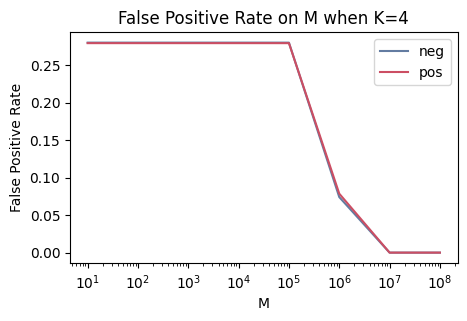

In [15]:
fpr_fig(m_s, [fpr[0] for fpr in fpr_ms], [fpr[1] for fpr in fpr_ms], "M", "False Positive Rate", "False Positive Rate on M when K=4")

In [16]:
k_s = [1, 2, 4, 8, 16]

print("====================================")
print("            Test on K")
print("====================================")

fpr_ks = []
for k in k_s:
    fpr_ks.append(test_on_m_and_k(1e6, k))

            Test on K
M=1000000.0, K=1
	 Time: 2.258026123046875
	 False Positive Rate:
	 neg: 93297 / 751256 	 12.42%
	 pos: 106020 / 832564 	 12.73%
M=1000000.0, K=2
	 Time: 2.37044620513916
	 False Positive Rate:
	 neg: 54458 / 751256 	 7.25%
	 pos: 64355 / 832564 	 7.73%
M=1000000.0, K=4
	 Time: 2.655308246612549
	 False Positive Rate:
	 neg: 55595 / 751256 	 7.40%
	 pos: 65404 / 832564 	 7.86%
M=1000000.0, K=8
	 Time: 3.188485860824585
	 False Positive Rate:
	 neg: 75736 / 751256 	 10.08%
	 pos: 85883 / 832564 	 10.32%
M=1000000.0, K=16
	 Time: 4.066158056259155
	 False Positive Rate:
	 neg: 161181 / 751256 	 21.45%
	 pos: 178378 / 832564 	 21.43%


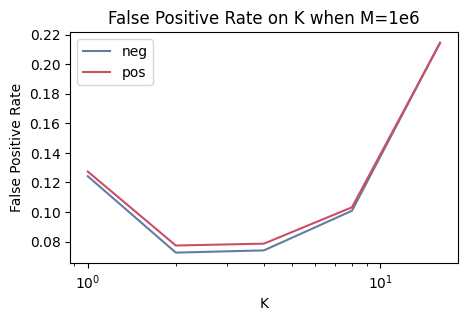

In [17]:
fpr_fig(k_s, [fpr[0] for fpr in fpr_ks], [fpr[1] for fpr in fpr_ks], "K", "False Positive Rate", "False Positive Rate on K when M=1e6")

## **Task3: Count-Min sketch**



In computing, the count–min sketch (CM sketch) is a probabilistic data structure that serves as a frequency table of events in a stream of data. 

Here we use the query stream (neg_reviews or pos_reviews) from task 2.

### 1. Write a function that accurately counts the occurrence times of each word in neg_reviews or pos_reviews.

In [18]:
# Your code here, you can add cells if necessary

def accCount(words):
    dictionary = {}
    for word in words:
        if word in word_list:
            dictionary[word] = dictionary.get(word, 0) + 1
    return dictionary

neg_accCount = accCount(neg_reviews)
pos_accCount = accCount(pos_reviews)

### 2. Implement the Count-Min sketch by yourself. Set different width w and depth d of the internal data structure of CM-Sketch. Compare the influence of different w and d on the error.

In [19]:
# Your code here, you can add cells if necessary
class CountMin:
    def __init__(self, w, d):
        self.w = int(w)
        self.d = int(d)
        self.table=np.zeros((self.d, self.w), dtype=int)
        
    def add(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.w
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.w
        h = hash1
        for i in range(self.d):
            self.table[i][h] += 1
            h = (h + hash2) % self.w
            
    def count(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.w
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.w
        h = hash1
        min_count = self.table[0][h]
        for i in range(self.d):
            min_count = min(min_count, self.table[i][h])
            h = (h + hash2) % self.w
        return min_count
    
    def add_corpus(self, corpus):
        for word in corpus:
            self.add(word)

In [20]:
def compare_eval(w, d):

    def eval(w, d, corpus, accCount):
        cm = CountMin(w, d)
        cm.add_corpus(corpus)
        
        freq_cms = []
        freq_acc = []
        for word in word_list:
            freq_cms.append(cm.count(word))
            freq_acc.append(accCount.get(word, 0))
        
        freq_cms = np.array(freq_cms)
        freq_acc = np.array(freq_acc)

        return freq_cms, freq_acc

    neg_cms, neg_acc = eval(w, d, neg_reviews, neg_accCount)
    pos_cms, pos_acc = eval(w, d, pos_reviews, pos_accCount)

    neg_err = np.abs(neg_cms-neg_acc)
    pos_err = np.abs(pos_cms-pos_acc)

    neg_tpr = neg_err[neg_acc > 0]
    pos_tpr = pos_err[pos_acc > 0]

    negs = (neg_err.mean(), neg_err.max(), neg_err.min())
    poss = (pos_err.mean(), pos_err.max(), pos_err.min())
    negs_tpr = (neg_tpr.mean(), neg_tpr.max(), neg_tpr.min())
    poss_tpr = (pos_tpr.mean(), pos_tpr.max(), pos_tpr.min())

    print("w={}, d={}".format(w, d))
    print("\t Error:")
    print("\t neg: {} \t Avg Error: {} \t Max: {} \t Min: {}".format( neg_err, negs[0], negs[1], negs[2] ))
    print("\t pos: {} \t Avg Error: {} \t Max: {} \t Min: {}".format( pos_err, poss[0], poss[1], poss[2] ))
    print("\t Error for True Positive Samples Only:")
    print("\t neg: {} \t Avg Error: {} \t Max: {} \t Min: {}".format( neg_tpr, negs_tpr[0], negs_tpr[1], negs_tpr[2] ))
    print("\t pos: {} \t Avg Error: {} \t Max: {} \t Min: {}".format( pos_tpr, poss_tpr[0], poss_tpr[1], poss_tpr[2] ))
    print()
    
    return negs, poss, negs_tpr, poss_tpr

In [21]:
ds = [4, 32, 128, 400, 4000]

print("====================================")
print("            Test on D")
print("====================================")

fpr_ds = []
for d in ds:
    fpr_ds.append(compare_eval(1000, d))

            Test on D
w=1000, d=4
	 Error:
	 neg: [152  86 137 ...  80 101 171] 	 Avg Error: 163.15797343876724 	 Max: 15512 	 Min: 14
	 pos: [181 121 209 ... 115 105 213] 	 Avg Error: 187.5098083941606 	 Max: 15467 	 Min: 30
	 Error for True Positive Samples Only:
	 neg: [ 86 137 122 ...  80 101 171] 	 Avg Error: 164.40589316183227 	 Max: 2071 	 Min: 14
	 pos: [121 146 116 ... 115 105 213] 	 Avg Error: 188.5333042285144 	 Max: 1854 	 Min: 30

w=1000, d=32
	 Error:
	 neg: [ 72  34  23 ...  80  67 116] 	 Avg Error: 82.5066065152744 	 Max: 15428 	 Min: 14
	 pos: [ 70  90  41 ... 102  68  93] 	 Avg Error: 97.00985063530683 	 Max: 15356 	 Min: 17
	 Error for True Positive Samples Only:
	 neg: [ 34  23  77 ...  80  67 116] 	 Avg Error: 82.86363039768999 	 Max: 2058 	 Min: 14
	 pos: [ 90  50  79 ... 102  68  93] 	 Avg Error: 96.79256579767993 	 Max: 1779 	 Min: 17

w=1000, d=128
	 Error:
	 neg: [37 34 23 ... 72 67 77] 	 Avg Error: 60.24050419032171 	 Max: 15369 	 Min: 12
	 pos: [37 75 41 ...

In [22]:
ws = [10, 100, 1000, 10000, 100000]

print("====================================")
print("            Test on W")
print("====================================")

fpr_ws = []
for w in ws:
    fpr_ws.append(compare_eval(w, 400))

            Test on W
w=10, d=400
	 Error:
	 neg: [41645 60400 41642 ... 77650 90534 44616] 	 Avg Error: 47388.34182802784 	 Max: 93256 	 Min: 35032
	 pos: [ 45586  63170  45586 ...  90349 103116  51311] 	 Avg Error: 52281.75310894837 	 Max: 105710 	 Min: 37560
	 Error for True Positive Samples Only:
	 neg: [60400 41642 49518 ... 77650 90534 44616] 	 Avg Error: 47333.41376821105 	 Max: 93255 	 Min: 35032
	 pos: [ 63170  69771  60705 ...  90349 103116  51311] 	 Avg Error: 52236.91773730822 	 Max: 105709 	 Min: 37560

w=100, d=400
	 Error:
	 neg: [2029 2300 2215 ... 2657 1891 2065] 	 Avg Error: 2170.1574623208976 	 Max: 37457 	 Min: 1413
	 pos: [2486 2857 2375 ... 3115 2374 2324] 	 Avg Error: 2461.725639530954 	 Max: 44928 	 Min: 1569
	 Error for True Positive Samples Only:
	 neg: [2300 2215 1981 ... 2657 1891 2065] 	 Avg Error: 2159.721879511747 	 Max: 37456 	 Min: 1413
	 pos: [2857 2198 2286 ... 3115 2374 2324] 	 Avg Error: 2449.38412124236 	 Max: 44926 	 Min: 1569

w=1000, d=400
	 Err

In [23]:
import matplotlib.pyplot as plt

def fpr_fig_fill(xs, ys1, ys2, xlabel, ylabel, title, label1="neg", label2="pos", color=1, ylim=None):
    if color == 1:
        colors = ["#637ca1", "#cc4e63"]
    elif color == 2:
        colors = ["#e6b070", "#2196a1"]
    elif color == 3:
        colors = ["#637ca1", "#e6b070"]
    elif color == 4:
        colors = ["#cc4e63", "#2196a1"]

    plt.figure(figsize=(5, 3))
    plt.plot(xs, ys1[0], label=label1, color=colors[0])
    plt.fill_between(xs, ys1[1], ys1[2], alpha=0.3, color=colors[0])
    plt.xscale("log")
    plt.plot(xs, ys2[0], label=label2, color=colors[1])
    plt.fill_between(xs, ys2[1], ys2[2], alpha=0.3, color=colors[1])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    if ylim:
        if isinstance(ylim, tuple) and len(ylim) == 2:
            plt.ylim(ylim)
        elif ylim == "log":
            plt.yscale("log")
        
    plt.title(title)
    plt.legend()
    plt.show()

In [24]:
def ploting(xs, fpr_xs, xlabel, ylabel, title, label1="neg", label2="pos", color=1, ylim=None, idx=(0,1)):

    neg_mean = [fpr[idx[0]][0] for fpr in fpr_xs]
    neg_max_ = [fpr[idx[0]][1] for fpr in fpr_xs]
    neg_min_ = [fpr[idx[0]][2] for fpr in fpr_xs]

    pos_mean = [fpr[idx[1]][0] for fpr in fpr_xs]
    pos_max_ = [fpr[idx[1]][1] for fpr in fpr_xs]
    pos_min_ = [fpr[idx[1]][2] for fpr in fpr_xs]

    fpr_fig_fill(xs, (neg_mean, neg_max_, neg_min_), (pos_mean, pos_max_, pos_min_), 
                 xlabel, ylabel, title, label1=label1, label2=label2, color=color, ylim=ylim)

### The impacts of D and W on the Effects of CountMin, on the entire dataset or on true positive samples only

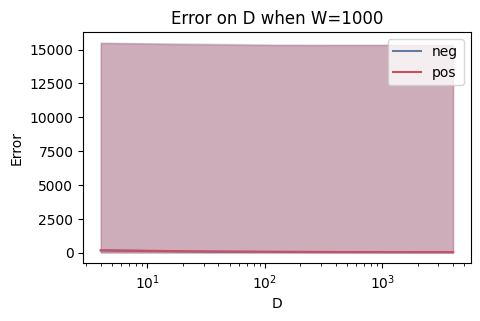

In [25]:
ploting(ds, fpr_ds, "D", "Error", "Error on D when W=1000")

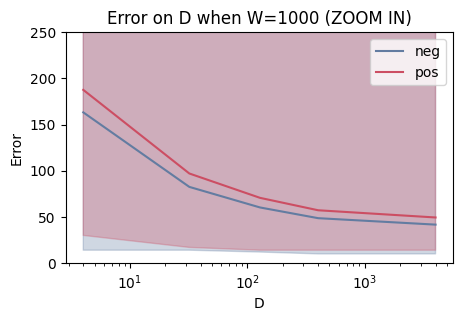

In [26]:
ploting(ds, fpr_ds, "D", "Error", "Error on D when W=1000 (ZOOM IN)", ylim=(0, 250))

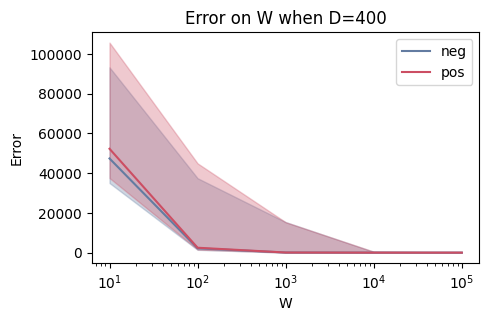

In [27]:
ploting(ws, fpr_ws, "W", "Error", "Error on W when D=400",)

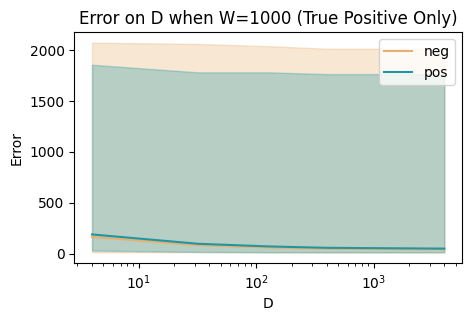

In [28]:
ploting(ds, fpr_ds, "D", "Error", "Error on D when W=1000 (True Positive Only)", color=2, idx=(2,3))

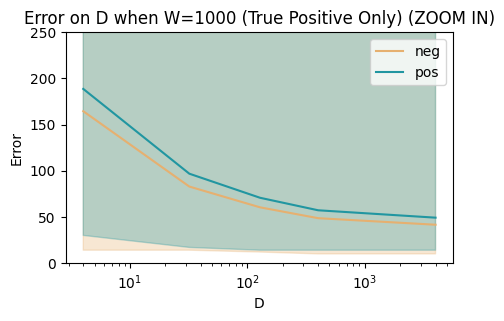

In [29]:
ploting(ds, fpr_ds, "D", "Error", "Error on D when W=1000 (True Positive Only) (ZOOM IN)", color=2, idx=(2,3), ylim=(0, 250))

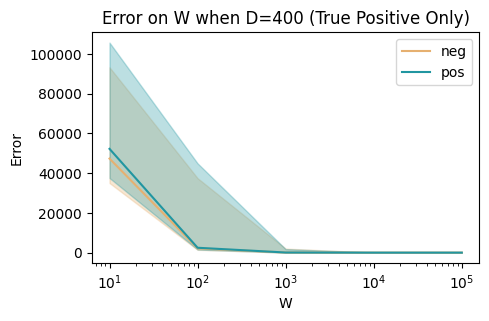

In [30]:
ploting(ws, fpr_ws, "W", "Error", "Error on W when D=400 (True Positive Only)", color=2, idx=(2,3))

### Compare the difference of impacts of W and D on CountMin on the Entire Dataset and on True Positive Samples Only

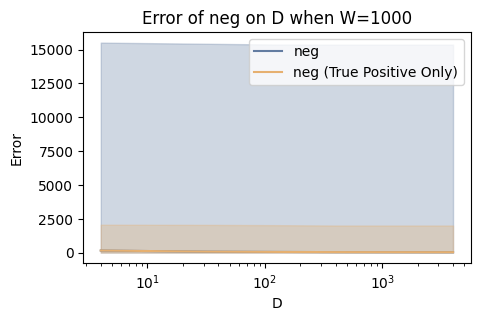

In [31]:
ploting(ds, fpr_ds, "D", "Error", "Error of neg on D when W=1000", label1="neg", label2="neg (True Positive Only)", color=3, idx=(0,2))

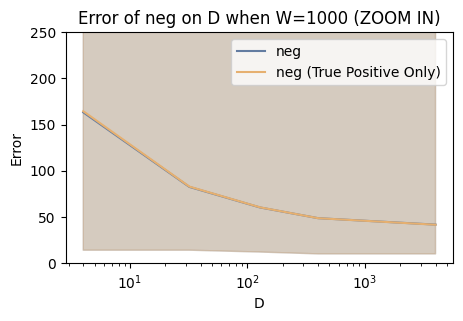

In [32]:
ploting(ds, fpr_ds, "D", "Error", "Error of neg on D when W=1000 (ZOOM IN)", label1="neg", label2="neg (True Positive Only)", color=3, idx=(0,2), ylim=(0, 250))

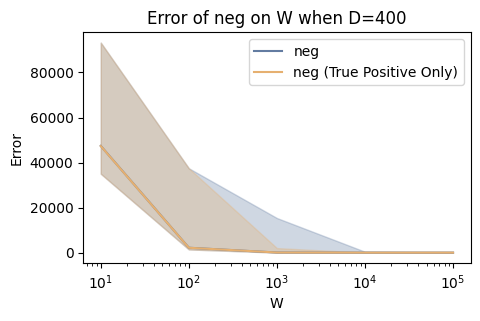

In [33]:
ploting(ws, fpr_ws, "W", "Error", "Error of neg on W when D=400", label1="neg", label2="neg (True Positive Only)", color=3, idx=(0,2))

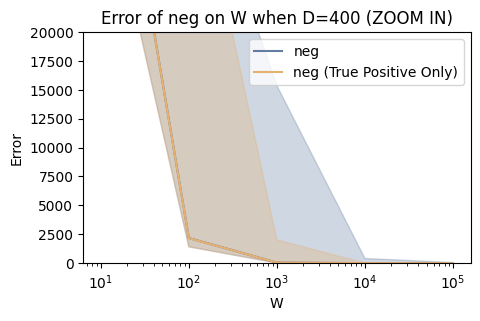

In [34]:
ploting(ws, fpr_ws, "W", "Error", "Error of neg on W when D=400 (ZOOM IN)", label1="neg", label2="neg (True Positive Only)", color=3, idx=(0,2), ylim=(0,20000))